In [1]:
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import datasets
from torchvision.transforms.functional import InterpolationMode
import torchvision.transforms.functional as TF
from matplotlib import pyplot as plt
from einops import rearrange, reduce, repeat

In [9]:
## datasets
train_data = datasets.MNIST(root="./data", download=True, train=True)
test_data = datasets.MNIST(root="./data", download=True, train=False)

100.0%
100.0%
100.0%
100.0%


In [14]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train

In [13]:
train_data.data.shape

torch.Size([60000, 28, 28])

In [15]:
one_data = train_data.data[0]

In [16]:
one_data.shape

torch.Size([28, 28])

In [ ]:
one_data/255.0

tensor(255, dtype=torch.uint8)

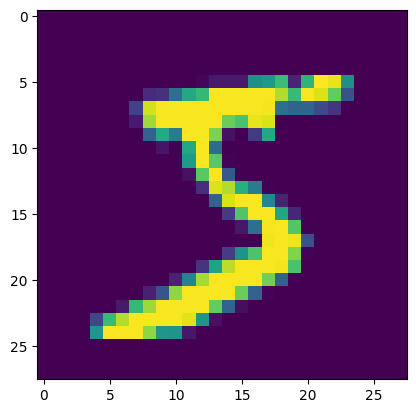

In [29]:
plt.imshow(one_data/255.0)

In [18]:
train_data.targets[0]

tensor(5)

In [19]:
x = np.array([1,2,3,4,5])
k = np.array([1,2,3])

In [21]:
np.convolve(x, k[::-1], 'valid')

array([14, 20, 26])

In [25]:
np.array([3, 4, 5]) @ k

np.int64(26)

In [26]:
## B C H W  # 4D , Image : 2D 
## 3D => B C L
## B C T D H W => 64 channel 
## <= 10 (I can be wrong )

In [39]:
torch.manual_seed(1)
input_img = torch.rand((1, 1, 4, 4))

In [40]:
input_img

tensor([[[[0.7576, 0.2793, 0.4031, 0.7347],
          [0.0293, 0.7999, 0.3971, 0.7544],
          [0.5695, 0.4388, 0.6387, 0.5247],
          [0.6826, 0.3051, 0.4635, 0.4550]]]])

In [47]:
torch.manual_seed(2)
kernel = torch.rand([1, 1, 2, 2 ])
## kernel -> i o h w

In [49]:
kernel

tensor([[[[0.6147, 0.3810],
          [0.6371, 0.4745]]]])

In [50]:
input_img

tensor([[[[0.7576, 0.2793, 0.4031, 0.7347],
          [0.0293, 0.7999, 0.3971, 0.7544],
          [0.5695, 0.4388, 0.6387, 0.5247],
          [0.6826, 0.3051, 0.4635, 0.4550]]]])

In [48]:
# patches -> img2col

In [53]:
# floor((H + 2*padding - dialation*(k - 1) - 1)/ stride + 1 )
# 4 + 2*0 - 1*(2 - 1) - 1 = 2 + 1 = 3
import math
def get_size(H, p, d, k, s):
    return math.floor( (H + 2*p - d*(k-1) - 1)/s + 1)


In [54]:
get_size(4, 0, 1, 2, 1)

3

In [55]:
F.unfold?

Signature:
F.unfold(
    input: torch.Tensor,
    kernel_size: None,
    dilation: None = 1,
    padding: None = 0,
    stride: None = 1,
) -> torch.Tensor
Docstring:
Extract sliding local blocks from a batched input tensor.

.. warning::
    Currently, only 4-D input tensors (batched image-like tensors) are
    supported.

.. warning::

    More than one element of the unfolded tensor may refer to a single
    memory location. As a result, in-place operations (especially ones that
    are vectorized) may result in incorrect behavior. If you need to write
    to the tensor, please clone it first.


See :class:`torch.nn.Unfold` for details
File:      d:\learning_pytorch\pytorch_session\pytorch_sessions\.venv\lib\site-packages\torch\nn\functional.py
Type:      function

In [57]:
input_img

tensor([[[[0.7576, 0.2793, 0.4031, 0.7347],
          [0.0293, 0.7999, 0.3971, 0.7544],
          [0.5695, 0.4388, 0.6387, 0.5247],
          [0.6826, 0.3051, 0.4635, 0.4550]]]])

In [60]:
kernel.flip(0,1)

tensor([[[[0.6147, 0.3810],
          [0.6371, 0.4745]]]])

In [59]:
patch = F.unfold(input_img, kernel_size=2, dilation=1,padding=0)

In [64]:
patch.shape

torch.Size([1, 4, 9])

In [ ]:
kernel

torch.Size([1, 1, 2, 2])

In [70]:
kernel_flatten = rearrange( kernel, '1 1 h w -> h w' )

In [75]:
kernel_flatten.flatten().reshape(1, 4)

tensor([[0.6147, 0.3810, 0.6371, 0.4745]])

In [ ]:
kernel_flatten.flatten().reshape(1, 4).shape

torch.Size([1, 4])

In [77]:
output= torch.einsum('b p l, o p -> b o l', patch, kernel_flatten.flatten().reshape(1, 4))

In [78]:
output.reshape(3,3)

tensor([[0.9703, 1.0233, 1.1386],
        [0.8938, 1.2256, 1.1874],
        [1.0969, 0.9274, 1.1037]])

In [79]:
one_data = one_data/255.0

In [80]:
one_data.shape

torch.Size([28, 28])

In [84]:
one_data.unsqueeze(dim=0).unsqueeze(dim=0).shape

torch.Size([1, 1, 28, 28])

In [85]:
sobel_kernel = torch.tensor([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
])

In [86]:
img = one_data.unsqueeze(dim=0).unsqueeze(dim=0)

In [87]:
patch = F.unfold(img, kernel_size=3, dilation=1,padding=0)

In [89]:
patch.shape

torch.Size([1, 9, 676])

In [93]:
sobel_kernel_flatten = sobel_kernel.reshape(1,9).to(torch.float32)

In [94]:
output= torch.einsum('b p l, o p -> b o l', patch,sobel_kernel_flatten)

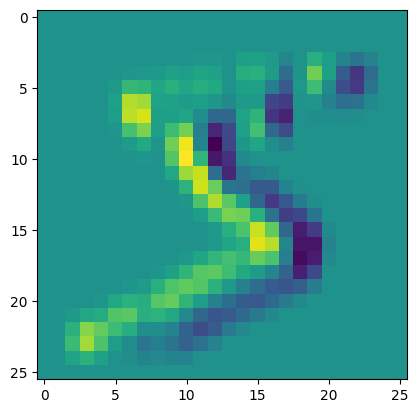

In [98]:
plt.imshow(output.reshape(26, 26))

In [96]:
676/26

26.0

In [100]:
import torch.nn as nn

In [ ]:
nn.Conv2d(1, 1, 3)

Init signature:
nn.Conv2d(
    in_channels: int,
    out_channels: int,
    kernel_size: Union[int, Tuple[int, int]],
    stride: Union[int, Tuple[int, int]] = 1,
    padding: Union[str, int, Tuple[int, int]] = 0,
    dilation: Union[int, Tuple[int, int]] = 1,
    groups: int = 1,
    bias: bool = True,
    padding_mode: str = 'zeros',
    device=None,
    dtype=None,
) -> None
Docstring:     
Applies a 2D convolution over an input signal composed of several input
planes.

In the simplest case, the output value of the layer with input size
:math:`(N, C_{\text{in}}, H, W)` and output :math:`(N, C_{\text{out}}, H_{\text{out}}, W_{\text{out}})`
can be precisely described as:

.. math::
    \text{out}(N_i, C_{\text{out}_j}) = \text{bias}(C_{\text{out}_j}) +
    \sum_{k = 0}^{C_{\text{in}} - 1} \text{weight}(C_{\text{out}_j}, k) \star \text{input}(N_i, k)


where :math:`\star` is the valid 2D `cross-correlation`_ operator,
:math:`N` is a batch size, :math:`C` denotes a number of channels,
:

In [ ]:
## Dropout -> Dropout
## Dropout1D, Dropout2D, Dropout3D
## BatchNorm
## MaxPool
## LayerNorm

## nn.Dropout
## .forward() ## 99%
## .__call__() ## 